In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from weather_tools import state_years
from energy_tools import read_region

In [2]:
df_NY_temperature = state_years('NY', 2015, 2019)

In [3]:
df_NY_temperature.head()

,2015,2016,2017,2018,2019,M/D
0,25.3,40.454545,33.416667,15.000000,35.1,01/01
1,29.6,34.545455,36.083333,13.400000,40.9,01/02
2,34.6,32.272727,33.083333,17.250000,28.0,01/03
3,33.9,33.818182,39.333333,18.153846,33.9,01/04
4,45.8,21.600000,39.250000,20.833333,35.5,01/05


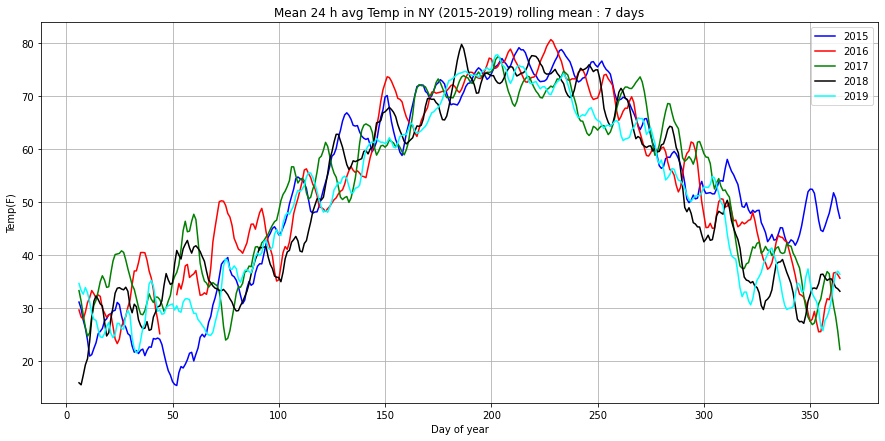

In [28]:
#df_NY_energy = read_region('NY')


fig,ax =plt.subplots(1,1)
fig.set_size_inches(15, 7)

ax.plot(df_NY_temperature.index, df_NY_temperature['2015'].rolling(7, win_type='boxcar').mean().values,'b-', label = '2015')
ax.plot(df_NY_temperature.index, df_NY_temperature['2016'].rolling(7, win_type='boxcar').mean().values,'r-',label = '2016')
ax.plot(df_NY_temperature.index, df_NY_temperature['2017'].rolling(7, win_type='boxcar').mean().values,'g-',label = '2017')
ax.plot(df_NY_temperature.index, df_NY_temperature['2018'].rolling(7, win_type='boxcar').mean().values,'k-',label = '2018')
ax.plot(df_NY_temperature.index, df_NY_temperature['2019'].rolling(7, win_type='boxcar').mean().values,'-', color ='cyan',label = '2019')
ax.set_xlabel('Day of year')
ax.set_ylabel('Temp(F)')
ax.set_title('Mean 24 h avg Temp in NY (2015-2019) rolling mean : 7 days')
plt.legend()
plt.grid()
plt.show()

In [29]:
df_NY_energy = read_region('New York')

In [42]:
df_NY_energy.head(50)

Forecast   Demand
Date       Hour                   
2015-07-01 1      16045.0  16891.0
           2          0.0  16027.0
           3          0.0  15541.0
           4          0.0  15283.0
           5          0.0  15304.0
           6          0.0  15874.0
           7          0.0  17161.0
           8          0.0  18690.0
           9          0.0  19956.0
           10         0.0  20971.0
           11         0.0  21849.0
           12         0.0  22471.0
           13         0.0  22809.0
           14         0.0  23260.0
           15         0.0  23606.0
           16         0.0  23778.0
           17         0.0  23804.0
           18         0.0  23664.0
           19         0.0  22984.0
           20         0.0  22262.0
           21         0.0  21746.0
           22         0.0  21525.0
           23         0.0  20149.0
           24         0.0  18493.0
2015-07-02 1      16893.0  17090.0
           2      16256.0  16052.0
           3      15665.0  15356.0
           4      15274.0  14936.0
           5      15185.0  14884.0
           6      15325.0  15314.0
           7      16160.0  16591.0
           8      17721.0  18271.0
           9      19122.0  19470.0
           10     20140.0  20364.0
           11     20935.0  21181.0
           12     21494.0  21714.0
           13     21846.0  22057.0
           14     22160.0  22313.0
           15     22431.0  22337.0
           16     22632.0  22136.0
           17     22650.0  21972.0
           18     22605.0  21717.0
           19     22037.0  21071.0
           20     21253.0  20473.0
           21     20651.0  20195.0
           22     20485.0  19896.0
           23     19491.0  18717.0
           24     18106.0  17352.0
2015-07-03 1      16584.0  16108.0
           2      15631.0  15179.0

In [50]:
rolling_mean = df_NY_energy.groupby(level=0)['Demand'].sum().rolling(7, win_type='boxcar').mean()
#.rolling(7, win_type='boxcar').mean()

In [51]:
rolling_mean.head(30)

Date
2015-07-01              NaN
2015-07-02              NaN
2015-07-03              NaN
2015-07-04              NaN
2015-07-05              NaN
2015-07-06              NaN
2015-07-07    465424.428571
2015-07-08    473463.000000
2015-07-09    477186.142857
2015-07-10    487240.142857
2015-07-11    497674.000000
2015-07-12    505676.428571
2015-07-13    511093.428571
2015-07-14    507392.857143
2015-07-15    502447.714286
2015-07-16    498525.000000
2015-07-17    495016.000000
2015-07-18    497754.857143
2015-07-19    507605.714286
2015-07-20    518426.142857
2015-07-21    524214.000000
2015-07-22    524475.285714
2015-07-23    529307.714286
2015-07-24    532581.571429
2015-07-25    530187.428571
2015-07-26    521914.428571
2015-07-27    512851.857143
2015-07-28    516030.000000
2015-07-29    531653.285714
2015-07-30    546037.142857
Name: Demand, dtype: float64

In [77]:
rolling_mean.index[183]

Timestamp('2015-12-31 00:00:00')

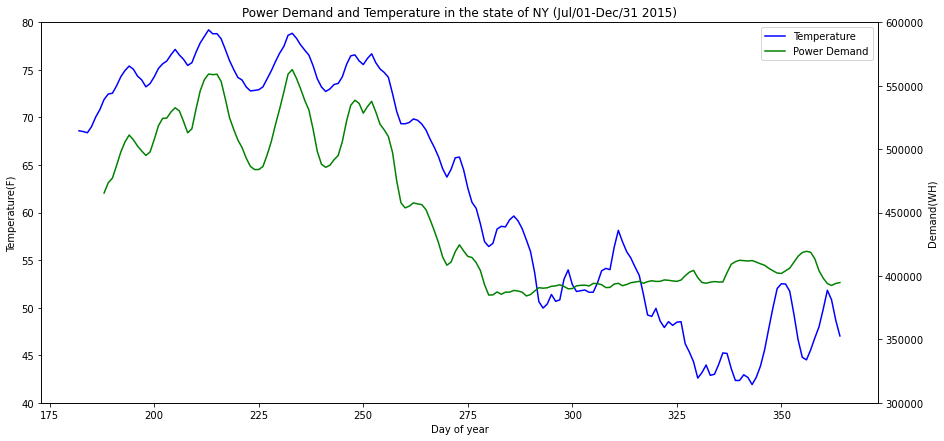

In [93]:
fig,ax1 =plt.subplots()
fig.set_size_inches(15, 7)

ax2 = ax1.twinx()

line1, =ax1.plot(df_NY_temperature.index[182:], df_NY_temperature['2015'].rolling(7, win_type='boxcar').mean().values[182:],'b-', label = 'Temperature')
line2, =ax2.plot( range(182,365,1), df_NY_energy.groupby(level=0)['Demand'].sum().rolling(7, win_type='boxcar').mean().values[:183] ,'g-', label = 'Power Demand')

lines = [line1, line2]

ax1.legend(lines, [l.get_label() for l in lines])

ax1.set_ylim(40,80)
ax2.set_ylim(300000,600000)

ax1.set_xlabel('Day of year')
ax1.set_ylabel('Temperature(F)')
ax2.set_ylabel('Demand(WH)')

ax1.set_title('Power Demand and Temperature in the state of NY (Jul/01-Dec/31 2015)')

plt.show()